In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tfx.components import CsvExampleGen, StatisticsGen, SchemaGen, ExampleValidator, Transform, Trainer, Tuner
from tfx.proto import example_gen_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from utils import clean_text, normalize_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
DATA_ROOT = "dataset"
DATA_CLEAN = "data_clean"

# Prepare data

In [3]:
dataset = pd.read_csv(DATA_ROOT + "/fake_job_postings.csv")

In [4]:
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
dataset.dropna(inplace=True)

In [7]:
dataset = dataset.drop(columns=['job_id', 'telecommuting', 'has_questions', 'has_company_logo'])

In [8]:
df = dataset

In [9]:
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
15,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,120000-150000,Jungle Ventures is the leading Singapore based...,About Vault Dragon Vault Dragon is Dropbox for...,Key Superpowers3-5 years of high-pressure sale...,"Basic: SGD 120,000Equity negotiable for a rock...",Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,0
23,"Vice President, Sales and Sponsorship (Busines...","US, CA, Carlsbad",Businessfriend.com,100000-120000,"WDM Group is an innovative, forward thinking d...",#URL_eda2500ddcedb60957fcd7f5b164e092966f8c4e8...,"Job Requirements:A reputation as a ""go-getter""...",Businessfriend will offer a competitive six fi...,Full-time,Executive,Unspecified,Internet,Sales,0
98,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
102,Marketing Administrator,"GB, WAR, Coventry",Marketplace,15000-18000,Renewable Energy and Environmental Protection ...,The job is to support the growth of the #URL_9...,"Computer literateAble to work with HTML, altho...",For a suitably motivated and success orientate...,Full-time,Entry level,Bachelor's Degree,Internet,Marketing,0


# Information about data

In [10]:
fraudulent = df[df['fraudulent'] == 1]['fraudulent'].count()
non_fraudulent = df[df['fraudulent'] == 0]['fraudulent'].count()

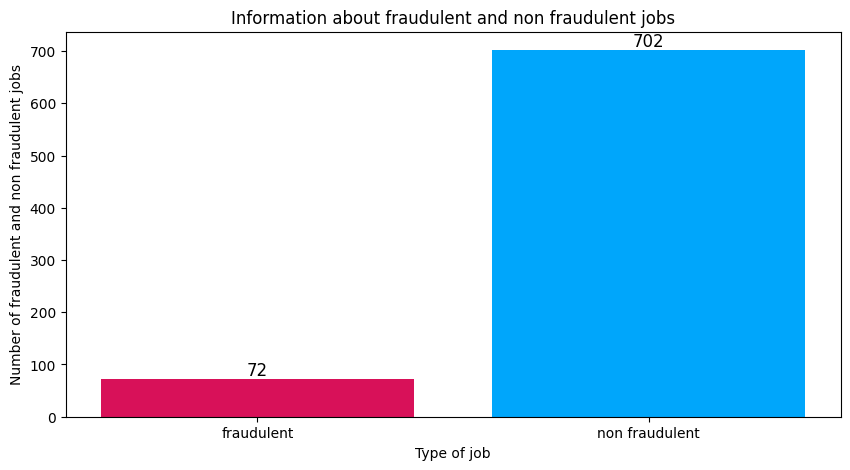

In [11]:
fig = plt.figure(figsize=(10, 5))

plt.bar(['fraudulent', 'non fraudulent'], [fraudulent, non_fraudulent], color=['#d81159', '#00a6fb'])

plt.text(0, fraudulent, fraudulent, ha='center', va='bottom', fontsize=12)
plt.text(1, non_fraudulent, non_fraudulent, ha='center', va='bottom', fontsize=12)

plt.title("Information about fraudulent and non fraudulent jobs")
plt.xlabel("Type of job")
plt.ylabel("Number of fraudulent and non fraudulent jobs")
plt.show()

.
___

In [12]:
employment_type = df.groupby(['employment_type'])['employment_type'].count()
employment_type_key = list(employment_type.keys())
employment_type_value = list(employment_type.values)

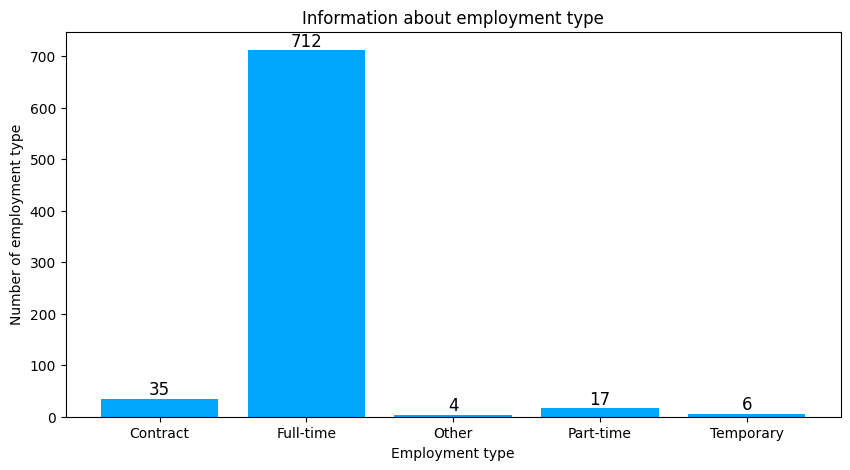

In [13]:
fig = plt.figure(figsize=(10, 5))

plt.bar(employment_type_key, employment_type_value, color="#00a6fb")

for i in range(len(employment_type_key)):
    plt.text(i, employment_type_value[i], employment_type_value[i], ha='center', va='bottom', fontsize=12)

plt.title("Information about employment type")
plt.xlabel("Employment type")
plt.ylabel("Number of employment type")
plt.show()

.
___

In [14]:
required_experience = df.groupby(['required_experience'])['required_experience'].count()
required_experience_key = list(required_experience.keys())
required_experience_value = list(required_experience.values)

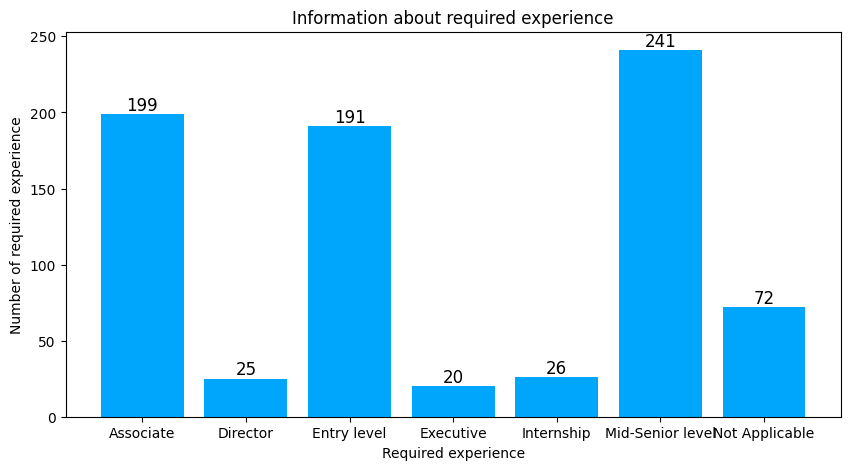

In [15]:
fig = plt.figure(figsize=(10, 5))

plt.bar(required_experience_key, required_experience_value, color="#00a6fb")

for i in range(len(required_experience_key)):
    plt.text(i, required_experience_value[i], required_experience_value[i], ha='center', va='bottom', fontsize=12)

plt.title("Information about required experience")
plt.xlabel("Required experience")
plt.ylabel("Number of required experience")
plt.show()

.
___

In [16]:
required_education = df.groupby(['required_education'])['required_education'].count()
required_education_key = list(required_education.keys())
required_education_value = list(required_education.values)

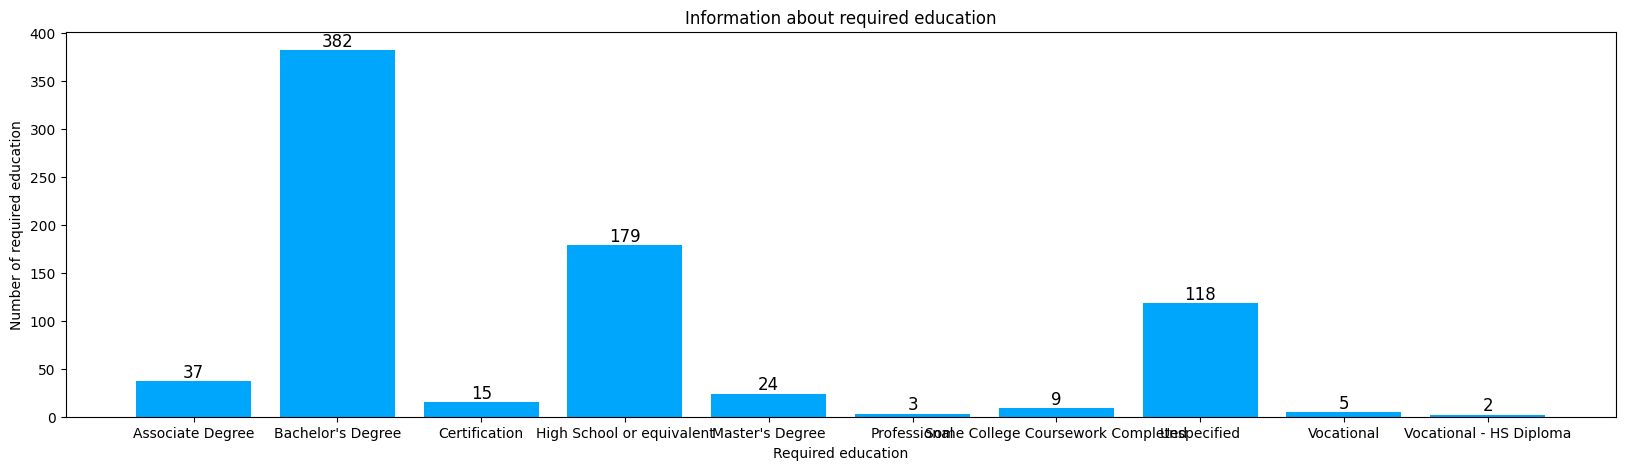

In [17]:
fig = plt.figure(figsize=(20, 5))

plt.bar(required_education_key, required_education_value, color="#00a6fb")

for i in range(len(required_education_key)):
    plt.text(i, required_education_value[i], required_education_value[i], ha='center', va='bottom', fontsize=12)

plt.title("Information about required education")
plt.xlabel("Required education")
plt.ylabel("Number of required education")
plt.show()

.
___

In [18]:
function = df.groupby(['function'])['function'].count()
function

function
Accounting/Auditing         7
Administrative             22
Advertising                 5
Art/Creative                6
Business Analyst            6
Business Development       13
Consulting                  4
Customer Service           87
Data Analyst                3
Design                     17
Distribution                1
Education                   3
Engineering               117
Finance                    17
Financial Analyst           5
General Business            1
Health Care Provider        4
Human Resources            15
Information Technology    111
Legal                       2
Management                 22
Manufacturing               2
Marketing                  64
Other                      38
Product Management          4
Production                  6
Project Management         10
Public Relations            3
Purchasing                  1
Quality Assurance           9
Research                    2
Sales                     148
Strategy/Planning           4
S

.
___

In [19]:
industry = df.groupby(['industry'])['industry'].count()
industry

industry
Accounting                           6
Apparel & Fashion                    1
Automotive                          19
Aviation & Aerospace                 1
Banking                              2
                                    ..
Transportation/Trucking/Railroad     8
Utilities                            2
Veterinary                           1
Warehousing                          2
Writing and Editing                  1
Name: industry, Length: 68, dtype: int64

# Data Cleansing

In [20]:
df.isnull().sum()

title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [21]:
df.fillna(" ", inplace=True)
df.isna().sum()

title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [22]:
df['full_description'] = df[
    ['title', 'location', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits',
     'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'department']].apply(
    lambda x: ' '.join(x), axis=1)

df.drop(columns=['title',
                 'location',
                 'salary_range',
                 'company_profile',
                 'description',
                 'requirements',
                 'benefits',
                 'employment_type',
                 'required_experience',
                 'required_education',
                 'industry',
                 'function',
                 'department'], inplace=True)

In [23]:
df.head()

,fraudulent,full_description
6,0,"Head of Content (m/f) DE, BE, Berlin 20000-280..."
15,0,"VP of Sales - Vault Dragon SG, 01, Singapore 1..."
23,0,"Vice President, Sales and Sponsorship (Busines..."
98,1,"IC&E Technician US, , Stocton, CA 95000-115000..."
102,0,"Marketing Administrator GB, WAR, Coventry 1500..."


In [24]:
df['full_description'] = df['full_description'].apply(clean_text)

In [25]:
df['full_description'] = df['full_description'].apply(normalize_text)

In [26]:
df.head()

,fraudulent,full_description
6,0,head content f de berlin 20000 28000 found 200...
15,0,vp sale vault dragon sg 01 singapore 120000 15...
23,0,vice president sale sponsorship businessfriend...
98,1,ic e technician us stocton ca 95000 115000 sta...
102,0,marketing administrator gb war coventry 15000 ...


In [27]:
df.to_csv(os.path.join(DATA_CLEAN, "fake_job_postings_clean.csv"), index=False)

# Prepare pipeline

In [28]:
PIPELINE_NAME = "real-or-fake-jobs-pipeline"
SCHEMA_PIPELINE_NAME = "real-or-fake-jobs-tfdv-schema"

PIPELINE_ROOT = os.path.join('celvineadiputra-pipelines', PIPELINE_NAME)

METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')

SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

In [29]:
interactive_context = InteractiveContext(pipeline_root=PIPELINE_ROOT)

## Data Ingestion
##### ExampleGen

In [30]:
output = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name="train", hash_buckets=8),
        example_gen_pb2.SplitConfig.Split(name="eval", hash_buckets=2)
    ])
)
example_gen = CsvExampleGen(input_base=DATA_CLEAN, output_config=output)

In [31]:
interactive_context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 7
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

## Data Validation
##### StatisticsGen

In [32]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs["examples"]
)

interactive_context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 8
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [67]:
interactive_context.show(statistics_gen.outputs["statistics"])

## Data Schema
##### SchemaGen

In [33]:
schema_gen = SchemaGen(statistics=statistics_gen.outputs["statistics"])
interactive_context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 9
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [34]:
interactive_context.show(schema_gen.outputs["schema"])

,Type,Presence,Valency,Domain
Feature name,,,,
'fraudulent',INT,required,,-
'full_description',BYTES,required,,-


## Example Validator

In [35]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)
interactive_context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 10
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [36]:
interactive_context.show(example_validator.outputs['anomalies'])

# Data Preprocessing
##### Transform

In [37]:
TRANSFORM_MODULE_FILE = "real_or_fake_job_transform.py"

In [38]:
%%writefile {TRANSFORM_MODULE_FILE}

import tensorflow as tf

LABEL_KEY = "fraudulent"
FEATURE_KEY = "full_description"


def transformed_name(key):
    return key + "_xf"


def preprocessing_fn(inputs):
    outputs = {}

    outputs[transformed_name(FEATURE_KEY)] = tf.strings.lower(inputs[FEATURE_KEY])

    outputs[transformed_name(LABEL_KEY)] = tf.cast(inputs[LABEL_KEY], tf.int64)

    return outputs

Overwriting real_or_fake_job_transform.py


In [39]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(TRANSFORM_MODULE_FILE)
)
interactive_context.run(transform)

INFO:tensorflow:Assets written to: celvineadiputra-pipelines\real-or-fake-jobs-pipeline\Transform\transform_graph\11\.temp_path\tftransform_tmp\80d82d23f33d4f85a61d31833bc18563\assets


INFO:tensorflow:Assets written to: celvineadiputra-pipelines\real-or-fake-jobs-pipeline\Transform\transform_graph\11\.temp_path\tftransform_tmp\80d82d23f33d4f85a61d31833bc18563\assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


ExecutionResult(
    component_id: Transform
    execution_id: 11
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

# Model Development

In [40]:
TRAINER_MODULE_FILE = "real_or_fake_job_trainer.py"

In [41]:
%%writefile {TRAINER_MODULE_FILE}
import tensorflow as tf
import tensorflow_transform as tft
from tensorflow.keras import layers
import os
import tensorflow_hub as hub
from tfx.components.trainer.fn_args_utils import FnArgs

LABEL_KEY = "fraudulent"
FEATURE_KEY = "full_description"


def transformed_name(key):
    """Renaming transformed features"""
    return key + "_xf"


def gzip_reader_fn(filenames):
    """Loads compressed data"""
    return tf.data.TFRecordDataset(filenames, compression_type='GZIP')


def input_fn(file_pattern,
             tf_transform_output,
             num_epochs,
             batch_size=64) -> tf.data.Dataset:
    """Get post_tranform feature & create batches of data"""

    # Get post_transform feature spec
    transform_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy())

    # create batches of data
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transform_feature_spec,
        reader=gzip_reader_fn,
        num_epochs=num_epochs,
        label_key=transformed_name(LABEL_KEY))
    return dataset


os.environ['TFHUB_CACHE_DIR'] = '/hub_chace'
embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")

VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 100

vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

embedding_dim = 16


def model_builder():
    inputs = tf.keras.Input(shape=(1,), name=transformed_name(FEATURE_KEY), dtype=tf.string)
    reshaped_narrative = tf.reshape(inputs, [-1])
    x = vectorize_layer(reshaped_narrative)
    x = layers.Embedding(VOCAB_SIZE, embedding_dim, name="embedding")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(0.01),
        metrics=[tf.keras.metrics.BinaryAccuracy()]

    )

    model.summary()
    return model


def _get_serve_tf_examples_fn(model, tf_transform_output):
    model.tft_layer = tf_transform_output.transform_features_layer()

    @tf.function
    def serve_tf_examples_fn(serialized_tf_examples):
        feature_spec = tf_transform_output.raw_feature_spec()

        feature_spec.pop(LABEL_KEY)

        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

        transformed_features = model.tft_layer(parsed_features)

        # get predictions using the transformed features
        return model(transformed_features)

    return serve_tf_examples_fn


def run_fn(fn_args: FnArgs) -> None:
    log_dir = os.path.join(os.path.dirname(fn_args.serving_model_dir), 'logs')

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, update_freq='batch'
    )

    es = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=10)
    mc = tf.keras.callbacks.ModelCheckpoint(fn_args.serving_model_dir, monitor='val_binary_accuracy', mode='max',
                                            verbose=1, save_best_only=True)

    # Load the transform output
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)

    # Create batches of data
    train_set = input_fn(fn_args.train_files, tf_transform_output, 10)
    val_set = input_fn(fn_args.eval_files, tf_transform_output, 10)
    vectorize_layer.adapt(
        [j[0].numpy()[0] for j in [
            i[0][transformed_name(FEATURE_KEY)]
            for i in list(train_set)]])

    # Build the model
    model = model_builder()

    # Train the model
    model.fit(x=train_set,
              validation_data=val_set,
              callbacks=[tensorboard_callback, es, mc],
              steps_per_epoch=1000,
              validation_steps=1000,
              epochs=10)
    signatures = {
        'serving_default':
            _get_serve_tf_examples_fn(model, tf_transform_output).get_concrete_function(
                tf.TensorSpec(
                    shape=[None],
                    dtype=tf.string,
                    name='examples'))
    }
    model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Writing real_or_fake_job_trainer.py


##### Trainer

In [43]:
from tfx.proto import trainer_pb2

trainer = Trainer(
    module_file=os.path.abspath(TRAINER_MODULE_FILE),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train']),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'])
)

interactive_context.run(trainer)

KeyboardInterrupt: 

##### Resolver

In [ ]:
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing

model_resolver = Resolver(
    strategy_class=LatestBlessedModelStrategy,
    model=Channel(type=Model),
    model_blessing=Channel(type=ModelBlessing)
).with_id('Latest_blessed_model_resolver')

interactive_context.run(model_resolver)

##### Evaluator

In [ ]:
import tensorflow_model_analysis as tfma

eval_config = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(label_key='is_sarcastic')],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
        tfma.MetricsSpec(metrics=[

            tfma.MetricConfig(class_name='ExampleCount'),
            tfma.MetricConfig(class_name='AUC'),
            tfma.MetricConfig(class_name='FalsePositives'),
            tfma.MetricConfig(class_name='TruePositives'),
            tfma.MetricConfig(class_name='FalseNegatives'),
            tfma.MetricConfig(class_name='TrueNegatives'),
            tfma.MetricConfig(class_name='BinaryAccuracy',
                              threshold=tfma.MetricThreshold(
                                  value_threshold=tfma.GenericValueThreshold(
                                      lower_bound={'value': 0.5}),
                                  change_threshold=tfma.GenericChangeThreshold(
                                      direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                                      absolute={'value': 0.0001})
                              )
                              )
        ])
    ]
)

In [ ]:
from tfx.components import Evaluator

evaluator = Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    baseline_model=model_resolver.outputs['model'],
    eval_config=eval_config)

interactive_context.run(evaluator)

In [ ]:
# Visualize the evaluation results
eval_result = evaluator.outputs['evaluation'].get()[0].uri
tfma_result = tfma.load_eval_result(eval_result)
tfma.view.render_slicing_metrics(tfma_result)
tfma.addons.fairness.view.widget_view.render_fairness_indicator(
    tfma_result
)

##### Pusher

In [ ]:
from tfx.components import Pusher
from tfx.proto import pusher_pb2

pusher = Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=pusher_pb2.PushDestination(
        filesystem=pusher_pb2.PushDestination.Filesystem(
            base_directory='serving_model_dir/real-or-fake-jobs-detection-model'))

)

interactive_context.run(pusher)